## Chapter 3

### 3.1 Coupon Feature Engineering.

Before we jump into feature engineering let me just mention that one should always do some data exploration. Within this dataset there is not much to explore that can drastically affect the techniques one would use afterwards. However, in the real world data exploration is **mandatory**. I will leave this to the reader. For example, it might be interesting to visualize the trends of sales per week/month, what are the features of the most popular coupons, age and gender distributions, etc. Here I concentrate on the algorithms. 

Moving into feature engineering, here I will manually generate a series of features. The reader might want to explore the use of this nice package [featuretools](https://github.com/Featuretools/featuretools), that can automate part of the process. 

To start with let's assume that we have information of the upcoming coupons with some time in advance and we can compute the features using the whole dataset.

In [38]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

sns.set()
%matplotlib inline

inp_dir = "./datasets/Ponpare/data_processed"
out_dir = "./datasets/Ponpare/data_processed"

In [39]:
# Coupon features
df_coupons_train = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_coupons_train.p'))
df_coupons_train['set_type'] = 2

df_coupons_valid = pd.read_pickle(os.path.join(inp_dir, 'valid', 'df_coupons_valid.p'))
df_coupons_valid['set_type'] = 1

df_coupons_test  = pd.read_pickle(os.path.join(inp_dir, 'test', 'df_coupons_test.p'))
df_coupons_test['set_type'] = 0

df_coupons = pd.concat(
    [ df_coupons_train, df_coupons_valid, df_coupons_test ],
    axis=0,
    ignore_index=True
)

df_coupons.head()

,capsule_text,genre_name,price_rate,catalog_price,discount_price,dispfrom,dispend,dispperiod,validfrom,validend,...,usable_date_sat,usable_date_sun,usable_date_holiday,usable_date_before_holiday,large_area_name,ken_name,small_area_name,coupon_id_hash,days_to_present,set_type
0,Food,Food,50,3000,1500,2011-07-08 12:00:00,2011-07-09 12:00:00,1,2011-07-10,2011-12-08,...,0.0,1.0,1.0,0.0,kanto,saitama,saitama,6b263844241eea98c5a97f1335ea82af,351,2
1,Food,Food,51,2080,1000,2011-07-01 12:00:00,2011-07-02 12:00:00,1,2011-07-03,2011-12-04,...,1.0,1.0,1.0,1.0,kanto,chiba,chiba,cc031f250e8bad1e24060263b9fc0ddd,358,2
2,Food,Food,50,7000,3500,2011-07-12 12:00:00,2011-07-15 12:00:00,3,2011-07-16,2012-01-11,...,1.0,1.0,1.0,1.0,kanto,chiba,chiba,ba5e9b7453ca52ff711635a5d2e8102d,347,2
3,Food,Food,50,3000,1500,2011-07-09 12:00:00,2011-07-11 12:00:00,2,2011-07-12,2011-12-01,...,0.0,1.0,1.0,1.0,kanto,chiba,chiba,3e1ffbedca3569f9e8032d401e8cb4e6,350,2
4,Food,Food,50,2000,1000,2011-07-05 12:00:00,2011-07-06 12:00:00,1,2011-07-07,2011-12-30,...,0.0,1.0,1.0,0.0,kanto,chiba,chiba,782934b6c815b4030ea204eef7d4a734,354,2


Let's have a slighly closer look to some of the features (you can go ahead and explore the rest)

Text(0.5, 1.0, 'Catalog Price Distribution')

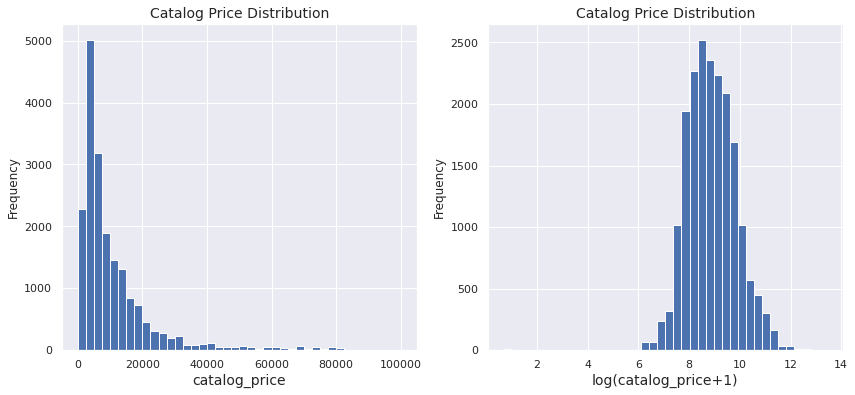

In [40]:
plt.subplot(1, 2, 1)
(df_coupons['catalog_price']).plot.hist(
    bins=40, figsize=(14, 6), edgecolor = 'white', range = [0, 100000]
)
plt.xlabel('catalog_price', fontsize=14)
plt.title('Catalog Price Distribution', fontsize=14)

plt.subplot(1, 2, 2)
np.log(df_coupons['catalog_price']+1).plot.hist(
    bins=40, figsize=(14,6), edgecolor='white'
)
plt.xlabel('log(catalog_price+1)', fontsize=14)
plt.title('Catalog Price Distribution', fontsize=14)

In [41]:
df_coupons.capsule_text.value_counts()

Delivery service         5841
Food                     3658
Hotel                    1943
Hair salon               1436
Japanese hotel           1351
Relaxation               1089
Other                     827
Spa                       758
Lesson                    673
Leisure                   664
Nail and eye salon        626
Gift card                 104
Resort inn                103
Japanse guest house        99
Health and medical         55
Beauty                     43
Web service                42
Vacation rental            28
Lodge                      24
Guest house                13
Correspondence course      12
Class                      11
Public hotel                9
Event                       4
Name: capsule_text, dtype: int64

In [42]:
df_coupons.genre_name.value_counts()

Delivery service            5841
Food                        3658
Hotel and Japanese hotel    3570
Hair salon                  1436
Relaxation                  1089
Other coupon                 873
Spa                          758
Lesson                       696
Leisure                      664
Nail and eye salon           626
Gift card                    104
Health and medical            55
Beauty                        43
Name: genre_name, dtype: int64

In [43]:
# columns with NaN
has_nan = df_coupons.isnull().any(axis=0)
has_nan = [df_coupons.columns[i] for i in np.where(has_nan)[0]]

print(has_nan)

['validfrom', 'validend', 'validperiod', 'usable_date_mon', 'usable_date_tue', 'usable_date_wed', 'usable_date_thu', 'usable_date_fri', 'usable_date_sat', 'usable_date_sun', 'usable_date_holiday', 'usable_date_before_holiday']


In [44]:
has_nan[3:]

['usable_date_mon',
 'usable_date_tue',
 'usable_date_wed',
 'usable_date_thu',
 'usable_date_fri',
 'usable_date_sat',
 'usable_date_sun',
 'usable_date_holiday',
 'usable_date_before_holiday']

#### NaN as another category

Interestingly, all features with NaN are time-related. There are a number of ways one could replace the `NaNs` (e.g. using the mode in the column). Here I will treat NaNs as if they were another category for all but the first 3 columns (Read Below).

In [45]:
for col in has_nan[3:]:
    df_coupons[col] = df_coupons[col].fillna(3).astype('int')

Let's have a quick look to the the feature validperiod

In [46]:
df_coupons[df_coupons.validperiod.isna()]['capsule_text'].value_counts()

Delivery service         5821
Lesson                    260
Gift card                  52
Correspondence course      12
Other                       1
Leisure                     1
Name: capsule_text, dtype: int64

On the other hand, 6147 of the 19413 `validperiod` values are `NaN`. 5821 of those are of type `"Delivery service"`. In the case of the `"Correspondence course"` *all* observations have `validperiod` value `NaN` and `"Other"` and `"Leisure"` only have one entry with `NaN`. There is a chance that those coupons with no `validperiod` "last forever". 

We will explore here two possible methods to fill `NaN` for the `validperiod` column

#### validperiod Method 1: NaN as another category

**Note**: maybe one could to consider coupons with a `validperiod` of 0 as a class. For now, we will simply use quatiles

In [50]:
df_coupons['validperiod_method1_cat'], validperiod_bins_method1 = \
    pd.qcut(df_coupons['validperiod'], q=4, labels=[0,1,2,3], retbins=True)

df_coupons.validperiod_method1_cat.cat.add_categories([4], inplace=True)

df_coupons['validperiod_method1_cat'].fillna(4, inplace=True)

#### validperiod Method 2: replace NaN first and then into categorical

Toma la moda (El valor con mayor frecuencia), de **validperiod** que es el nume de dias entre **validfrom** y **validend**. 

In [52]:
validperiod_mode = df_coupons.validperiod.mode().values[0]
validperiod_mode 

178.0

Categorias de cupones un **validperiod**:

In [51]:
caps_vals = list(df_coupons[df_coupons.validperiod.isna()]['capsule_text'].value_counts().index)
caps_vals

['Delivery service',
 'Lesson',
 'Gift card',
 'Correspondence course',
 'Other',
 'Leisure']

In [54]:
for ct in caps_vals:
    non_nan_values = df_coupons[
        
        (df_coupons.capsule_text == ct) &
        (~df_coupons.validperiod.isna())
        
    ]['validperiod'].values

    nan_idx = list(
        df_coupons[
            (df_coupons.capsule_text == ct) &
            (df_coupons.validperiod.isna())
        ].index
    )
    
    # Note that '50' is rather arbitray 
    if (len(nan_idx)>50) & (non_nan_values.size>0):
        replace_vals = np.random.choice(non_nan_values, len(nan_idx))
        df_coupons.loc[nan_idx, 'validperiod'] = replace_vals
    
    elif (len(nan_idx)<=50) & (non_nan_values.size>0):
        median = np.median(non_nan_values)
        df_coupons.loc[nan_idx, 'validperiod'] = median
    
    elif non_nan_values.size==0:
        df_coupons.loc[nan_idx, 'validperiod'] = validperiod_mode
        
        
df_coupons['validperiod_method2_cat'] = pd.cut(
    df_coupons['validperiod'],
    bins=validperiod_bins_method1, 
    labels=[0,1,2,3], 
    include_lowest=True
)

df_coupons['validperiod'] = df_coupons['validperiod'].astype('int')

In [12]:
# let's save the mappings. This dictionary will be fundamental in moving forward
dict_of_mappings = {}
dict_of_mappings['validperiod_cat'] = validperiod_bins_method1

#### validfrom and validend

In [13]:
# Let's now take care of validfrom and validend
valid_cols = ['validfrom', 'validend']

for col in valid_cols:
    valid_mode = df_coupons[col].dt.dayofweek.mode().values[0]

    # Method 1: NaN as another category
    new_colname_1 = col+"_method1_cat"
    df_coupons[new_colname_1] = df_coupons[col].dt.dayofweek
    df_coupons[new_colname_1] = df_coupons[new_colname_1].fillna(7).astype('int')

    # Method 2: replace and to category
    new_colname_2 = col+"_method2_cat"
    df_coupons[new_colname_2] = df_coupons[col].dt.dayofweek
    caps_vals = list(df_coupons[df_coupons[new_colname_2].isna()]['capsule_text'].value_counts().index)
    
    for ct in caps_vals:
        non_nan_values = df_coupons[(df_coupons.capsule_text == ct) &
            (~df_coupons[new_colname_2].isna())][new_colname_2].values
        nan_idx = list(df_coupons[(df_coupons.capsule_text == ct) &
            (df_coupons[new_colname_2].isna())].index)
    
        if (len(nan_idx)>50) & (non_nan_values.size>0):
            replace_vals = np.random.choice(non_nan_values, len(nan_idx))
            df_coupons.loc[nan_idx, new_colname_2] = replace_vals
        
        elif (len(nan_idx)<=50) & (non_nan_values.size>0):
            mode = stats.mode(non_nan_values).mode[0]
            df_coupons.loc[nan_idx, new_colname_2] = mode
        
        elif non_nan_values.size==0:
            df_coupons.loc[nan_idx, new_colname_2] = valid_mode
    
    df_coupons[new_colname_2] = df_coupons[new_colname_2].astype('int')

#### dispfrom, dispend and dispperiod

In [14]:
df_coupons['dispfrom_cat'] = df_coupons.dispfrom.dt.dayofweek
df_coupons['dispend_cat'] = df_coupons.dispend.dt.dayofweek

# also add dispperiod as categorical
df_coupons['dispperiod_cat'], dispperiod_bins = pd.qcut(df_coupons.dispperiod, q=4, labels=[0,1,2,3], retbins=True)
dict_of_mappings['dispperiod_cat'] = dispperiod_bins

#### price related features

In [15]:
df_coupons['price_rate_cat'], price_rate_bins = pd.qcut(df_coupons['price_rate'], q=3, labels=[0,1,2], retbins=True)

df_coupons['catalog_price_cat'], catalog_price_bins = pd.qcut(df_coupons['catalog_price'], q=3, labels=[0,1,2], retbins=True)

df_coupons['discount_price_cat'], discount_price_bins = pd.qcut(df_coupons['discount_price'], q=3, labels=[0,1,2], retbins=True)

In [16]:
# Update dictionary of mappings
dict_of_mappings['price_rate_cat'] = price_rate_bins
dict_of_mappings['catalog_price_cat'] = catalog_price_bins
dict_of_mappings['discount_price_cat'] = discount_price_bins

#### Final encoding

In [17]:
# Finally let's LabelEncode some additional features. I will do it
# manually since I want to keep the mappings (as opposed as using LabelEncoder in sklearn)

le_cols = ['capsule_text', 'genre_name', 'large_area_name', 'ken_name', 'small_area_name']


for col in le_cols:
    dict_of_mappings[col+"_cat"] = {}
    
    values = list(df_coupons[col].unique())
    
    labels = list(np.arange(len(values)))
    
    dict_of_mappings[col+"_cat"] = dict(zip(values,labels))
    
    df_coupons[col+'_cat'] = df_coupons[col].replace(dict_of_mappings[col+"_cat"])

drop_cols = le_cols + ['dispfrom', 'dispend', 'validfrom', 'validend', 'days_to_present']
df_coupons.drop(drop_cols, axis=1, inplace=True)


# for convenience later, let's add the suffix "cat" to usable_date columns
usable_date_cols_dict = {c:c+"_cat" for c in df_coupons.columns if 'usable' in c}

df_coupons.rename(index=str, columns=usable_date_cols_dict, inplace=True)


# split back to the original datasets
df_coupons_train = (df_coupons[df_coupons.set_type == 2]
    .drop('set_type', axis=1)
    .reset_index(drop=True))

df_coupons_valid = (df_coupons[df_coupons.set_type == 1]
    .drop('set_type', axis=1)
    .reset_index(drop=True))

df_coupons_test = (df_coupons[df_coupons.set_type == 0]
    .drop('set_type', axis=1)
    .reset_index(drop=True))

In [35]:
# Let's have a look to the resulting df
df_coupons.head()

,capsule_text,genre_name,price_rate,catalog_price,discount_price,dispfrom,dispend,dispperiod,validfrom,validend,...,usable_date_sun,usable_date_holiday,usable_date_before_holiday,large_area_name,ken_name,small_area_name,coupon_id_hash,days_to_present,set_type,validperiod_method2_cat
0,Food,Food,50,3000,1500,2011-07-08 12:00:00,2011-07-09 12:00:00,1,2011-07-10,2011-12-08,...,1.0,1.0,0.0,kanto,saitama,saitama,6b263844241eea98c5a97f1335ea82af,351,2,2
1,Food,Food,51,2080,1000,2011-07-01 12:00:00,2011-07-02 12:00:00,1,2011-07-03,2011-12-04,...,1.0,1.0,1.0,kanto,chiba,chiba,cc031f250e8bad1e24060263b9fc0ddd,358,2,2
2,Food,Food,50,7000,3500,2011-07-12 12:00:00,2011-07-15 12:00:00,3,2011-07-16,2012-01-11,...,1.0,1.0,1.0,kanto,chiba,chiba,ba5e9b7453ca52ff711635a5d2e8102d,347,2,3
3,Food,Food,50,3000,1500,2011-07-09 12:00:00,2011-07-11 12:00:00,2,2011-07-12,2011-12-01,...,1.0,1.0,1.0,kanto,chiba,chiba,3e1ffbedca3569f9e8032d401e8cb4e6,350,2,2
4,Food,Food,50,2000,1000,2011-07-05 12:00:00,2011-07-06 12:00:00,1,2011-07-07,2011-12-30,...,1.0,1.0,0.0,kanto,chiba,chiba,782934b6c815b4030ea204eef7d4a734,354,2,2


#### save

In [36]:
# save files
df_coupons_train.to_pickle(os.path.join(out_dir,"train","df_coupons_train_feat.p"))
df_coupons_valid.to_pickle(os.path.join(out_dir,"valid","df_coupons_valid_feat.p"))
df_coupons_test.to_pickle(os.path.join(out_dir,"test","df_coupons_test_feat.p"))

# save dictionary
pickle.dump(dict_of_mappings, open(os.path.join(out_dir, 'dict_of_mappings.p'), 'wb') )